# Experiments

In this notebook we ran the experiments that generated the results presented in the dissertation.

## Imports

In [ ]:
%matplotlib inline

from numpy import array, where, mean, unique, concatenate
from classification import FilterCondition
from feature_extraction import DataBase, Feature
from sklearn.cross_validation import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, recall_score, precision_score, f1_score, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict

import matplotlib.pyplot as plt
import matplotlib.transforms as mt

import warnings
warnings.filterwarnings("ignore")

## Display functions

Some functions to make the visualization of the results more pleasing.

In [2]:
from IPython.display import HTML, display

def get_template(filepath='template_results.html'):
    
    with open(filepath, 'r') as f:
        
        text =  f.read()
        
        return text

def print_evaluation(name, res):
    
    recall_0 = recall_score(*res, pos_label=0)
    precision_0 = precision_score(*res, pos_label=0)
    fscore_0 = f1_score(*res, pos_label=0)
    
    recall_1 = recall_score(*res, pos_label=1)
    precision_1 = precision_score(*res, pos_label=1)
    fscore_1 = f1_score(*res, pos_label=1)
    
    cm = confusion_matrix(*res)
    
    template = get_template()
    
    display(HTML(
        template.format(
            name, cm[0,0], cm[0,1], cm[1,0], cm[1,1],
            str(precision_0)[:5],
            str(recall_0)[:5],
            str(fscore_0)[:5],
            str(precision_1)[:5],
            str(recall_1)[:5],
            str(fscore_1)[:5],
            str(mean([precision_0, precision_1]))[:5],
            str(mean([recall_0, recall_1]))[:5],
            str(mean([fscore_0, fscore_1]))[:5],
        )
    ))

## Reading the databases

The features should have already been extracted.

In [4]:
# Reads the database
db = DataBase.load_from_file('splited_database_2.db')
test_db = DataBase.load_from_file('splited_database_testset_3.db')

## Run all combinations of classifiers, hyper-parameters and feature sets.

This function below is responsible to iterate running all combinations and displaying the results.

In [ ]:
def run_combinations(classifiers, features, params, db, test_db):
    
    train_filter = FilterCondition('splits', '==', 'train')
    train_1 = where(train_filter(db.data))[0]
    train_2 = where(train_filter(test_db.data))[0]
    
    label_1 = db.get_data(variables=['sharpness_class'], samples=train_1)[:,0]
    label_2 = test_db.get_data(variables=['sharpness_class'], samples=train_2)[:,0]
    
    label = concatenate([label_1, label_2], axis=0)
    
    for c, p in zip(classifiers, params):
        
        for f in features:
            
            data_1 = db.get_data(variables=f, samples=train_1)
            data_2 = test_db.get_data(variables=f, samples=train_2)
            data = concatenate([data_1, data_2], axis=0)
            
            cv_result = GridSearchCV(c, p, scoring='roc_auc', n_jobs=3, cv=5, verbose=1)
            cv_result.fit(data, label)

            mean_scores = cv_result.cv_results_['mean_test_score']
            print('============================================================================')
            print('Classifier =', c)
            print('Features =', f)
            print('Mean scores =', mean_scores)
            print('Max score =', mean_scores.max())
            print('Best Params =', cv_result.cv_results_['params'][mean_scores.argmax()])

And these structures below define the combinations.

In [ ]:
classifiers = [
    Pipeline(
        steps=[
            ('scaler', StandardScaler()),
            ('svm', SVC(random_state=5))
        ]
    ),
    AdaBoostClassifier(
        DecisionTreeClassifier(random_state=5),
        random_state=5
    )
]

params = [
    # For SVM
    [
        {
            'svm__C': [0.01, 0.1, 1., 5.], 
            'svm__class_weight': [{1:1., 0:1.}, {1:2., 0:1.}, {1:1.5, 0:1}, {1:1, 0:1.5}], 
            'svm__kernel':['linear']
        },
        {
            'svm__C': [0.01, 0.1, 1., 5.], 
            'svm__class_weight': [{1:1., 0:1.}, {1:2., 0:1.}, {1:3., 0:1.}, {1:4., 0:1.}],
            'svm__gamma': ['auto', 1/8694.0, 0.01], 
            'svm__kernel':['rbf']
        }
    ],
    # For AdaBoost
    [
        {
            'base_estimator__max_depth': [1, 2, 3, 4],
            'base_estimator__min_samples_split': [4, 6, 8],
            'base_estimator__max_features': [None],
            'base_estimator__class_weight': [{1:1., 0:1.}, {1:2., 0:1.}, {1:3., 0:1.}, {1:4., 0:1.}],
            'n_estimators': [11, 21, 31],
            'learning_rate': [1., 0.1, 0.5]
        }
    ]
]

features = [
    ['fft_features'],
    ['sharpness_behavior'],
    ['hog'],
    ['fft_features', 'sharpness_behavior'],
    ['fft_features', 'hog'],
    ['sharpness_behavior', 'hog'],
    ['fft_features', 'sharpness_behavior', 'hog']
]

run_combinations(classifiers, features, params, db, test_db)

## Selected model evaluation

First, the following code identify all samples marked as belonging to the training set as explained in the dissertation. Then creates the selected model object, which is an SVM.

In [5]:
train_filter = FilterCondition('splits', '==', 'train')
train_1 = where(train_filter(db.data))[0]
train_2 = where(train_filter(test_db.data))[0]

data_p1 = db.get_data(variables=['fft_features', 'sharpness_behavior', 'hog'], samples=train_1)
label_p1 = db.get_data(variables=['sharpness_class'], samples=train_1)[:,0]

data_p2 = test_db.get_data(variables=['fft_features', 'sharpness_behavior', 'hog'], samples=train_2)
label_p2 = test_db.get_data(variables=['sharpness_class'], samples=train_2)[:,0]

data = concatenate([data_p1, data_p2], axis=0)
label = concatenate([label_p1, label_p2])

model = Pipeline(
    steps=[
        ('scaler', StandardScaler()),
        ('svm', SVC(
            random_state=5,
            C = 5.,
            class_weight = {1:2, 0:1},
            gamma = 'auto',
            kernel = 'rbf'
        ))
    ]
)

Then, the model is trained using the training data.

In [6]:
model.fit(data, label)

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm', SVC(C=5.0, cache_size=200, class_weight={1: 2, 0: 1}, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=5, shrinking=True,
  tol=0.001, verbose=False))])

Get all data from the testing set.

In [7]:
test_filter = FilterCondition('splits', '==', 'test')
test = where(test_filter(test_db.data))[0]

test_data = test_db.get_data(variables=['fft_features', 'sharpness_behavior', 'hog'], samples=test)
test_label = test_db.get_data(variables=['sharpness_class'], samples=test)[:,0]

And finally, run the model on the testing set and compute the evaluation metrics.

In [9]:
test_filter = FilterCondition('splits', '==', 'test')
test = where(test_filter(test_db.data))[0]

test_data = test_db.get_data(variables=['fft_features', 'sharpness_behavior', 'hog'], samples=test)
test_label = test_db.get_data(variables=['sharpness_class'], samples=test)[:,0]

pred = model.predict(test_data)

print_evaluation('SVM final test set</br>FFT + SHB + HOG', [test_label, pred])

## Object detection experiment

The next code separate the data of both training and testing set, considering only the features extracted from the bounding boxes of the main objects. Then, it repeats the same evaluation procedure as done above using this specific data.

In [10]:
object_data_1 = db.get_data(variables=['object_features', 'object_hog'], samples=train_1)
object_data_2 = test_db.get_data(variables=['object_features', 'object_hog'], samples=train_2)
object_data = concatenate([object_data_1, object_data_2], axis=0)

test_object_data = test_db.get_data(variables=['object_features', 'object_hog'], samples=test)

object_model = Pipeline(
    steps=[
        ('scaler', StandardScaler()),
        ('svm', SVC(
            random_state=5,
            C = 5.,
            class_weight = {1:2, 0:1},
            gamma = 'auto',
            kernel = 'rbf'
        ))
    ]
)

object_model.fit(object_data, label)
# object_model = model

pred = object_model.predict(test_object_data)

print_evaluation('SVM Object</br>FFT + SHB + HOG', [test_label, pred])

## ROC Curves

Get the scores of each classification/metric and compute the ROC curve of each one, comparing it against the ground truth.

#### Utility functions:

This function removes the NAN values from an array and inverts its values so that the maximum previous value will now be equal to zero, and the previous zero equal to the maximum.

In [11]:
from numpy import isnan

def remove_nans(x):
    
    no_nans = where(isnan(x) == False)
    x = x[no_nans]
    x = x.max() - x
    
    return x, no_nans

This function adjusts the some Matplotlib parameters for the plots:

In [12]:
def set_plt_params(plt, shape=(1080, 960), dpi=210):
    
    plt.rcParams['figure.dpi'] = dpi
    width = int(shape[0]/dpi)
    height = int(shape[1]/dpi)
    plt.rcParams['figure.figsize'] = width, height
    
    print('setting dpi = {}, figsize = {}'.format(dpi, (height, width)))

This function is used to get the full path to save the plots:

In [13]:
img_full_path = lambda x: '/home/path/to/images/{}'.format(x)

#### Computing the ROC curves and displaying them

setting dpi = 150, figsize = (6, 7)
whole img auc = 0.95417611489
obj img auc = 0.993478101117
hong mod auc = 0.632757166653
hong adap auc = 0.566927542622
sieberth auc = 0.663825200862


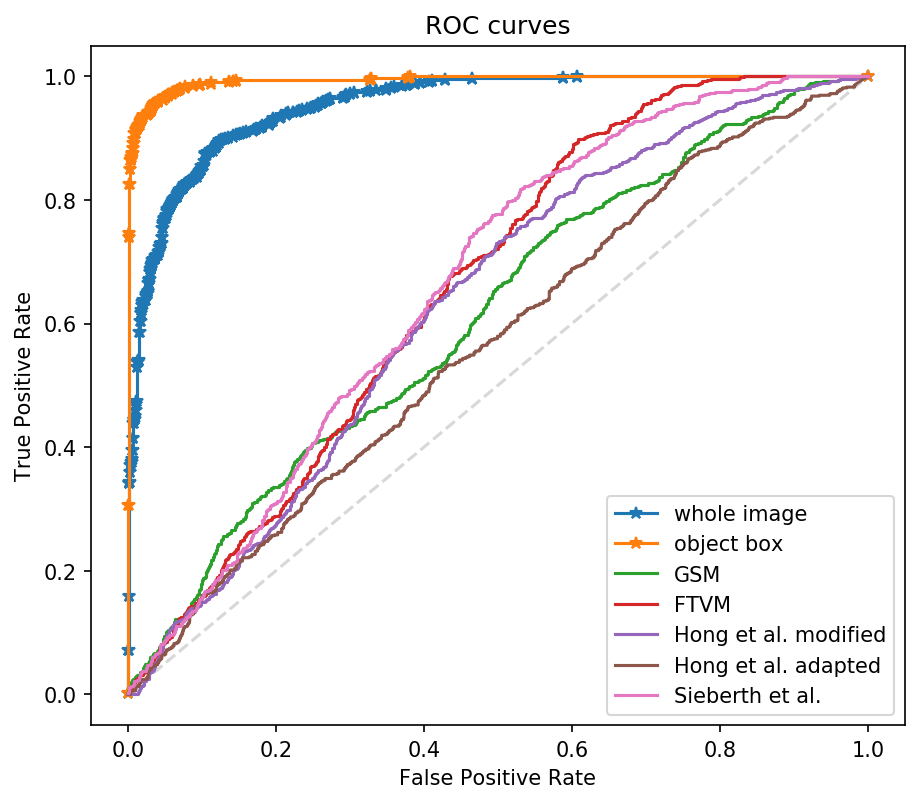

In [15]:
scores = model.decision_function(test_data)
object_scores = object_model.decision_function(test_object_data)
yuzhen_scores = test_db.get_data(variables=['yuzhen_fixed'], samples=test)
y2_scores = test_db.get_data(variables=['yuzhen_new'], samples=test)
sh = test_db.get_data(variables=['sharpness'], samples=test)
fft = test_db.get_data(variables=['fft_features'], samples=test)
sieds = test_db.get_data(variables=['sieberth'], samples=test)

yuzhen_scores, no_nans = remove_nans(yuzhen_scores)

y2_scores = y2_scores.max() - y2_scores

set_plt_params(plt, dpi=150)

plt.plot([0,1], [0,1], '--', alpha=0.3, color='gray')

fpr, tpf, _ = roc_curve(test_label, scores, 1)
plt.plot(fpr, tpf, '*-', label='whole image')
auc = roc_auc_score(test_label, scores)
print('whole img auc =', auc)

fpr, tpf, _ = roc_curve(test_label, object_scores, 1)
plt.plot(fpr, tpf, '*-', label='object box')
auc = roc_auc_score(test_label, object_scores)
print('obj img auc =', auc)

fpr, tpf, _ = roc_curve(test_label, sh, 1)
plt.plot(fpr, tpf, '-', label='GSM')

fpr, tpf, _ = roc_curve(test_label, (fft[:,0] + fft[:,1])/2, 1)
plt.plot(fpr, tpf, '-', label='FTVM')

fpr, tpf, _ = roc_curve(test_label, y2_scores, 1)
plt.plot(fpr, tpf, '-', label='Hong et al. modified')#, lw=3)
auc = roc_auc_score(test_label, y2_scores)
print('hong mod auc =', auc)

fpr, tpf, _ = roc_curve(test_label[no_nans[0]], yuzhen_scores, 1)
plt.plot(fpr, tpf, '-', label='Hong et al. adapted')#, lw=3)
auc = roc_auc_score(test_label, yuzhen_scores)
print('hong adap auc =', auc)

fpr, tpf, _ = roc_curve(test_label, sieds, 1)
plt.plot(fpr, tpf, '-', label='Sieberth et al.')#, lw=3)
auc = roc_auc_score(test_label, sieds)
print('sieberth auc =', auc)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves')
plt.legend(loc='lower right')

bbox = mt.Bbox(array([[0.3, 0.3], [6.4, 5.6]]))
# plt.savefig(img_full_path('roc_curves2.eps'), bbox_inches=bbox, pad_inches=0.)

plt.show()

# Show some images

The following code finds and shows some images from the testing set for some extreme results from the classifier:

### Hard blurred

These are the images that belong to the class *Blur*, but the classifier assigned them to the *Sharp* class with the highest "confidence".

setting dpi = 80, figsize = (7, 13)


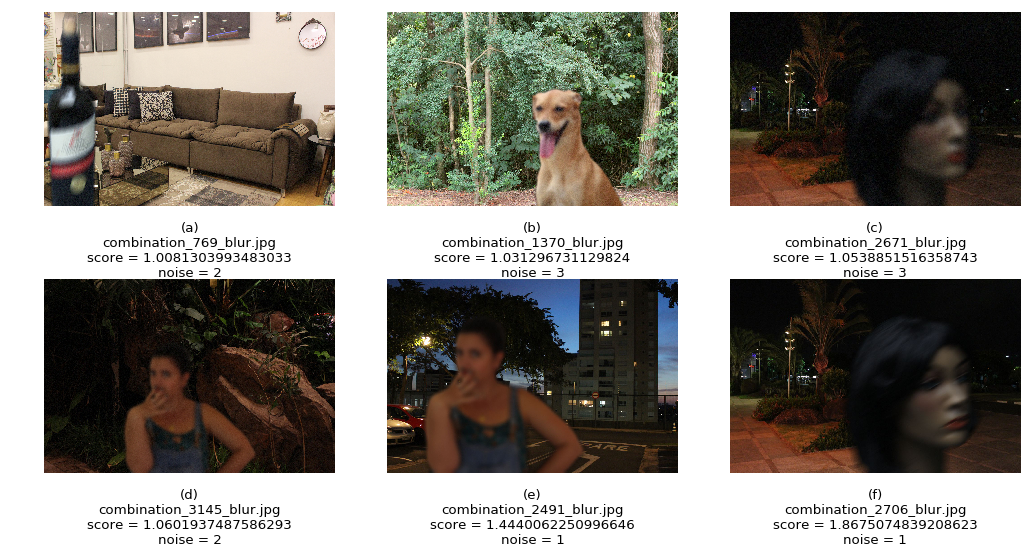

In [23]:
from numpy import argsort
from pre_processors import imread

set_plt_params(plt, (1080,600), dpi=80)

fig, ax = plt.subplots(2, 3)

the_score = scores

fnames = array(test_db.samples_path)[test]
sort_by_score = argsort(the_score)

idx_sort_wrong = where((the_score[sort_by_score] > 0).__and__(test_label[sort_by_score] == 0))[0]
bad_blur = fnames[sort_by_score[idx_sort_wrong[-6:]]]

folder = '../test_set/images/'
noise = test_db.get_data(variables=['noise'], samples=test)

fig_letter = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']

for i, f in enumerate(bad_blur):
    
    img = imread('{}{}'.format(folder, f))
    s = the_score[sort_by_score[idx_sort_wrong[-6:]]][i]
    n = noise[sort_by_score[idx_sort_wrong[-6:]]][i]
    
    row = i // 3
    column = i - row * 3
    ax[row, column].imshow(img)
    
    ax[row, column].axis('off')
    ax[row, column].set_title('{}\n{}\nscore = {}\nnoise = {}'.format(fig_letter[i], f, s, n), y=-0.4)
    
plt.tight_layout()
# bbox = mt.Bbox(array([[1.6, 0.], [12.7, 7.2]]))
# plt.subplots_adjust(hspace=0.5, wspace=0.01)
# plt.savefig(img_full_path('hard_blurred2.eps'), bbox_inches=bbox, pad_inches=0.)

plt.show()

### Hard sharp

These are the images that belong to the class *Sharp*, but the classifier assigned them to the *Blur* class with the highest "confidence".

setting dpi = 80, figsize = (7, 13)


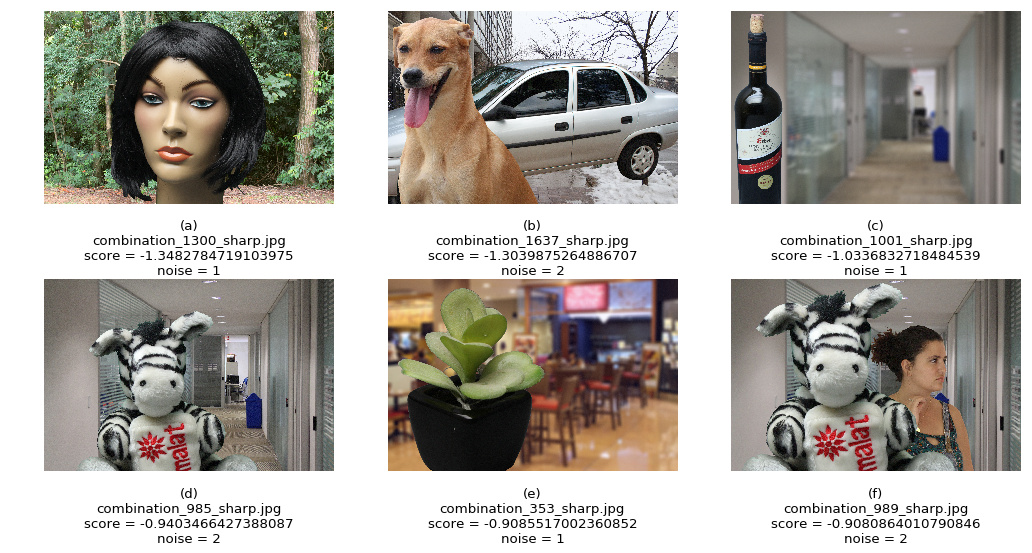

In [25]:
set_plt_params(plt, (1080,600), dpi=80)

fig, ax = plt.subplots(2, 3)

idx_sort_wrong = where((the_score[sort_by_score] < 0).__and__(test_label[sort_by_score] == 1))[0]
bad_sharp = fnames[sort_by_score[idx_sort_wrong[:6]]]

folder = '../test_set/images/'
noise = test_db.get_data(variables=['noise'], samples=test)

fig_letter = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']

# TODO: Add the filename and the noise level in the plots titles

for i, f in enumerate(bad_sharp):
    
    img = imread('{}{}'.format(folder, f))
    s = the_score[sort_by_score[idx_sort_wrong[:6]]][i]
    n = noise[sort_by_score[idx_sort_wrong[:6]]][i]
    
    row = i // 3
    column = i - row * 3
    ax[row, column].imshow(img)
    ax[row, column].axis('off')
    ax[row, column].set_title('{}\n{}\nscore = {}\nnoise = {}'.format(fig_letter[i], f, s, n), y=-0.4)
    
plt.tight_layout()
# plt.savefig(img_full_path('hard_sharp.eps'))
# bbox = mt.Bbox(array([[1.6, 0.], [12.7, 7.2]]))
# plt.subplots_adjust(hspace=0.5, wspace=0.01)
# plt.savefig(img_full_path('hard_sharp2.eps'), bbox_inches=bbox, pad_inches=0.)
plt.show()

### Easy blurred

These are the images that belong to the class *Blur* and the classifier predicted correctly with the highest "confidence".

setting dpi = 80, figsize = (7, 13)


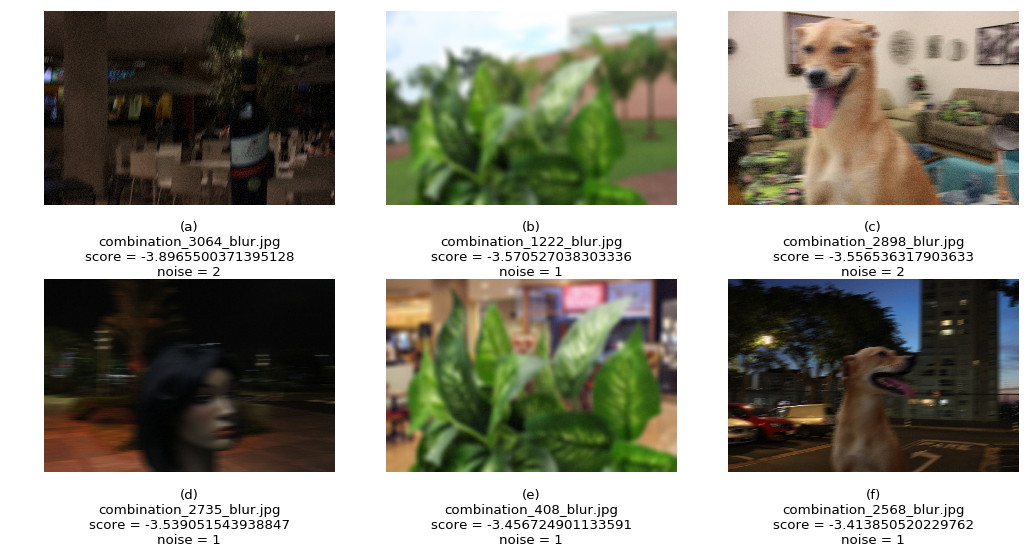

In [26]:
set_plt_params(plt, (1080,600), dpi=80)
fig, ax = plt.subplots(2, 3)

idx_sort_wrong = where((the_score[sort_by_score] < 0).__and__(test_label[sort_by_score] == 0))[0]
easy_blurr = fnames[sort_by_score[idx_sort_wrong[:6]]]

for i, f in enumerate(easy_blurr):
    
    img = imread('{}{}'.format(folder, f))
    s = the_score[sort_by_score[idx_sort_wrong[:6]]][i]
    n = noise[sort_by_score[idx_sort_wrong[:6]]][i]
    
    row = i // 3
    column = i - row * 3
    ax[row, column].imshow(img)
    ax[row, column].axis('off')
    ax[row, column].set_title('{}\n{}\nscore = {}\nnoise = {}'.format(fig_letter[i], f, s, n), y=-0.4)
    
plt.tight_layout()
# plt.savefig(img_full_path('easy_blurred.eps'))
# bbox = mt.Bbox(array([[1.6, 0.], [12.7, 7.2]]))
# plt.subplots_adjust(hspace=0.5, wspace=0.01)
# plt.savefig(img_full_path('easy_blurred2.eps'), bbox_inches=bbox, pad_inches=0.)
plt.show()

### Easy sharp

These are the images that belong to the class *Sharp* and the classifier predicted correctly with the highest "confidence".

setting dpi = 80, figsize = (7, 13)


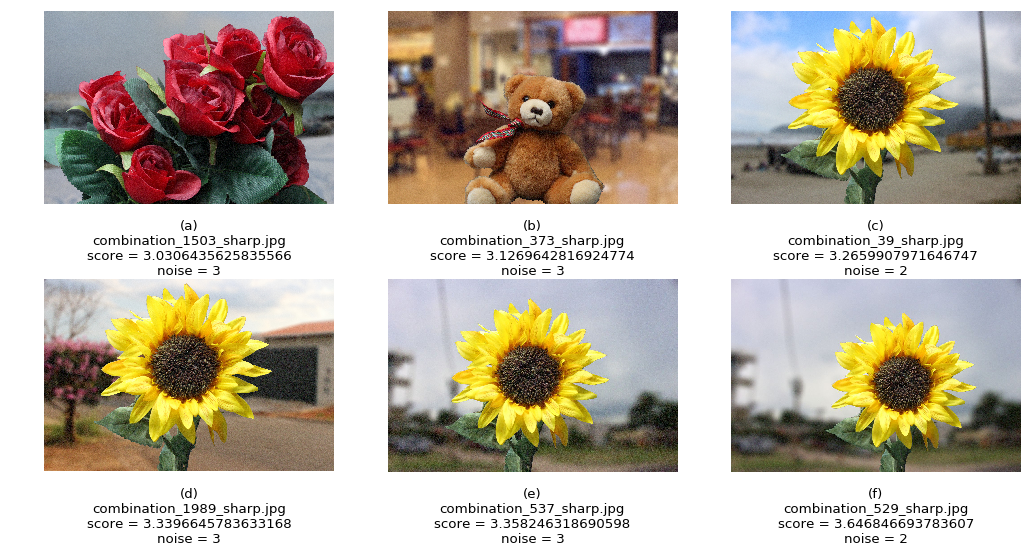

In [27]:
set_plt_params(plt, (1080,600), dpi=80)
fig, ax = plt.subplots(2, 3)

idx_sort_wrong = where((the_score[sort_by_score] > 0).__and__(test_label[sort_by_score] == 1))[0]
easy_sharp = fnames[sort_by_score[idx_sort_wrong[-6:]]]

for i, f in enumerate(easy_sharp):
    
    img = imread('{}{}'.format(folder, f))
    s = the_score[sort_by_score[idx_sort_wrong[-6:]]][i]
    n = noise[sort_by_score[idx_sort_wrong[-6:]]][i]
    
    row = i // 3
    column = i - row * 3
    ax[row, column].imshow(img)
    ax[row, column].axis('off')
    ax[row, column].set_title('{}\n{}\nscore = {}\nnoise = {}'.format(fig_letter[i], f, s, n), y=-0.4)
    
plt.tight_layout()
# plt.savefig(img_full_path('easy_sharp.eps'))
# bbox = mt.Bbox(array([[1.6, 0.], [12.7, 7.2]]))
# plt.subplots_adjust(hspace=0.5, wspace=0.01)
# plt.savefig(img_full_path('easy_sharp2.eps'), bbox_inches=bbox, pad_inches=0.)
plt.show()

# Noise and compression analysis

In this section we divided the test set according to the levels of noise and compression, separately, in order to analyze their impact on the classifier predictions.

### For noise first

setting dpi = 210, figsize = (4, 5)


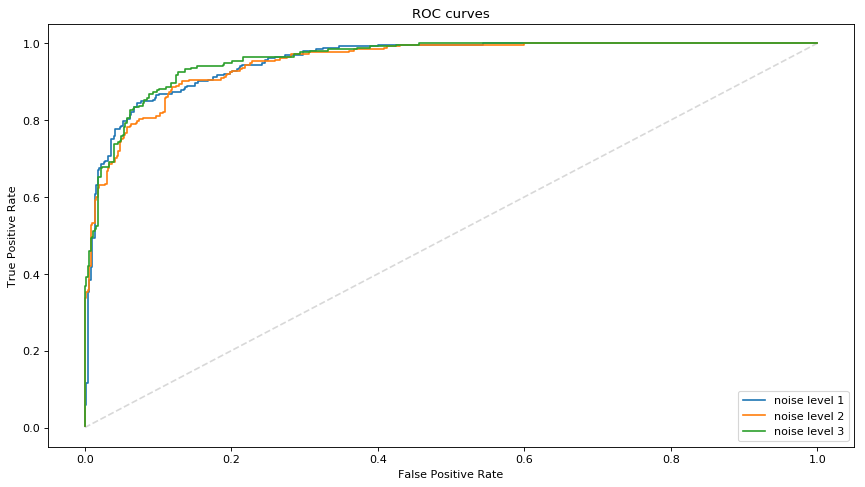

In [28]:
noise_filters = [
    FilterCondition('noise', '==', i+1).__and__(FilterCondition('splits', '==', 'test')) \
    for i in range(3)
]
noise_samples = [where(noise_filters[i](test_db.data))[0] for i in range(3)]

plt.plot([0,1], [0,1], '--', alpha=0.3, color='gray')

for i in range(3):
    
    dt = test_db.get_data(variables=['fft_features', 'sharpness_behavior', 'hog'], samples=noise_samples[i])
    l = test_db.get_data(variables=['sharpness_class'], samples=noise_samples[i])
    
    scores = model.decision_function(dt)
    pred = model.predict(dt)
    
    print_evaluation('For noise {}'.format(i+1), [l, pred])
    
    fpr, tpf, _ = roc_curve(l, scores, 1)
    plt.plot(fpr, tpf, label='noise level {}'.format(i+1))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves')
plt.legend(loc='lower right')
set_plt_params(plt, dpi=210)
# plt.savefig(img_full_path('roc_noise.eps'))
bbox = mt.Bbox(array([[0.05, 0.05], [4.6, 3.75]]))
# plt.savefig(img_full_path('roc_noise2.eps'), bbox_inches=bbox, pad_inches=0.)
plt.show()

### For compression now

In [29]:
compression_metadata = test_db.get_data(variables=['compression'], samples=test)
compression_values = unique(compression_metadata)
print('Results by noise:', compression_values)

Results by noise: [ 0  5 20]


setting dpi = 210, figsize = (4, 5)


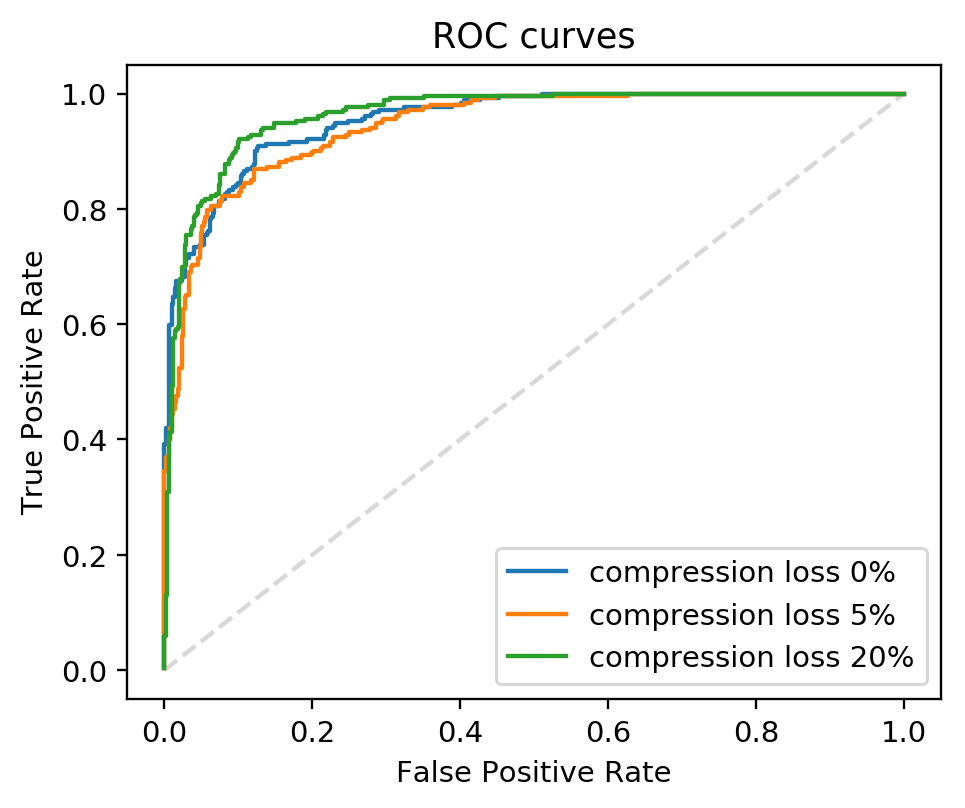

In [30]:
compression_filters = [
    FilterCondition('compression', '==', i).__and__(FilterCondition('splits', '==', 'test')) \
    for i in compression_values
]
compression_samples = [where(compression_filters[i](test_db.data))[0] for i in range(3)]

plt.plot([0,1], [0,1], '--', alpha=0.3, color='gray')

for i in range(3):
    
    dt = test_db.get_data(variables=['fft_features', 'sharpness_behavior', 'hog'], samples=compression_samples[i])
    l = test_db.get_data(variables=['sharpness_class'], samples=compression_samples[i])
    
    scores = model.decision_function(dt)
    pred = model.predict(dt)
    
    print_evaluation('For compression {}'.format(compression_values[i]), [l, pred])
    
    fpr, tpf, _ = roc_curve(l, scores, 1)
    plt.plot(fpr, tpf, label='compression loss {}%'.format(compression_values[i]))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves')
plt.legend(loc='lower right')
set_plt_params(plt, dpi=210)
# plt.savefig(img_full_path('roc_compression.eps'))
bbox = mt.Bbox(array([[0.05, 0.05], [4.6, 3.75]]))
# plt.savefig(img_full_path('roc_compression2.eps'), bbox_inches=bbox, pad_inches=0.)
plt.show()

# Per type of blur analysis

Now we divide the test set in two subsets called *Easier* and *Harder* cases. The first one is formed by all images that are either completely blur or completely sharp. The later are composed by the images that have either the background or the foreground blurred.

We run our SVM and compare its results with other methods. First, we divide the test set:

In [31]:
easy_filter = FilterCondition(
    'blur_method', '==', 'whole'
).__or__(
    FilterCondition('motion_method', '==', 'camera_motion')
).__or__(
    FilterCondition(
        'blur_method', '==', 'none'
    ).__and__(
        FilterCondition('motion_method', '==', 'none')
    )
).__and__(
    FilterCondition('splits', '==', 'test')
)

hard_filter = FilterCondition(
    'blur_method', '==', 'hyperfocal'
).__or__(
    FilterCondition('blur_method', '==', 'macro')
).__or__(
    FilterCondition('motion_method', '==', 'object_motion')
).__and__(
    FilterCondition('splits', '==', 'test')
)

easy_samples = where(easy_filter(test_db.data))[0]
hard_samples = where(hard_filter(test_db.data))[0]

easy_dt = test_db.get_data(variables=['fft_features', 'sharpness_behavior', 'hog'], samples=easy_samples)
easy_l = test_db.get_data(variables=['sharpness_class'], samples=easy_samples)

hard_dt = test_db.get_data(variables=['fft_features', 'sharpness_behavior', 'hog'], samples=hard_samples)
hard_l = test_db.get_data(variables=['sharpness_class'], samples=hard_samples)

Then, we show the ROC curves of the evaluated methods, starting with our SVM:

setting dpi = 210, figsize = (4, 5)


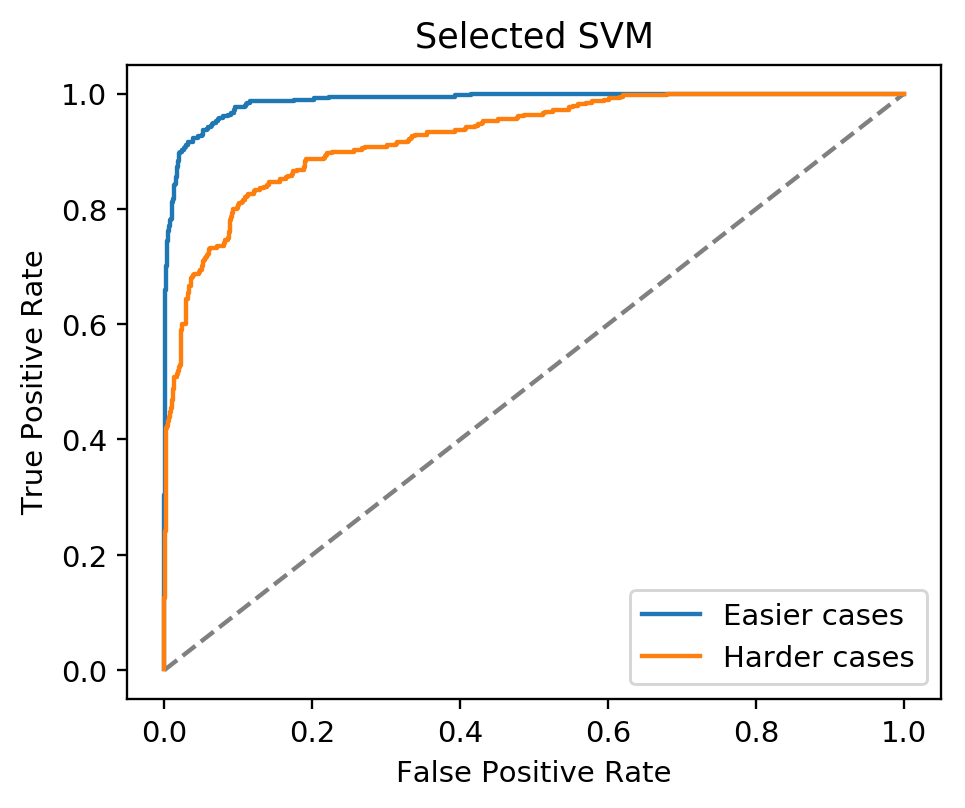

In [32]:
easy_scores = model.decision_function(easy_dt)
easy_pred = model.predict(easy_dt)

hard_scores = model.decision_function(hard_dt)
hard_pred = model.predict(hard_dt)

print_evaluation('For the easy ones', [easy_l, easy_pred])
print_evaluation('For the hard ones', [hard_l, hard_pred])
    
plt.plot([0,1], [0,1], '--', color='gray')
    
fpr, tpf, _ = roc_curve(easy_l, easy_scores, 1)
plt.plot(fpr, tpf, label='Easier cases')

fpr, tpf, _ = roc_curve(hard_l, hard_scores, 1)
plt.plot(fpr, tpf, label='Harder cases')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Selected SVM')
plt.legend(loc='lower right')
set_plt_params(plt, dpi=210)
bbox = mt.Bbox(array([[0.05, 0.05], [4.6, 3.75]]))
# plt.savefig(img_full_path('roc_blur_type.eps'), bbox_inches=bbox, pad_inches=0.)
plt.show()

Then, for the adaptation of Hong et al.'s method:

(1134,) (1134,)
(1134,) (1134,)
setting dpi = 210, figsize = (4, 5)


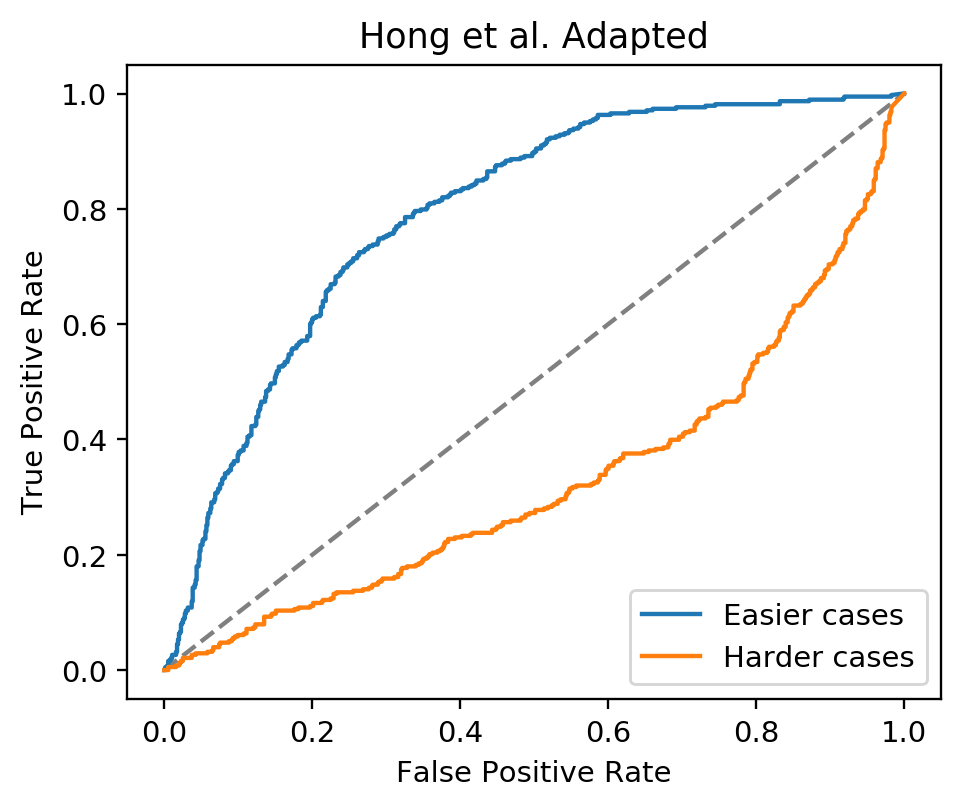

In [33]:
easy_yuzhen, easy_no_nans = remove_nans(test_db.get_data(variables=['yuzhen_fixed'], samples=easy_samples))
hard_yuzhen, hard_no_nans = remove_nans(test_db.get_data(variables=['yuzhen_fixed'], samples=hard_samples))

print(easy_yuzhen.shape, easy_no_nans[0].shape)
print(hard_yuzhen.shape, hard_no_nans[0].shape)
    
plt.plot([0,1], [0,1], '--', color='gray')
    
fpr, tpf, _ = roc_curve(easy_l[easy_no_nans[0]], easy_yuzhen, 1)
plt.plot(fpr, tpf, label='Easier cases')

fpr, tpf, _ = roc_curve(hard_l[hard_no_nans[0]], hard_yuzhen, 1)
plt.plot(fpr, tpf, label='Harder cases')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Hong et al. Adapted')
plt.legend(loc='lower right')
set_plt_params(plt, dpi=210)
bbox = mt.Bbox(array([[0.05, 0.05], [4.6, 3.75]]))
# plt.savefig(img_full_path('roc_yuzhen_fixed_blur_type.eps'), bbox_inches=bbox, pad_inches=0.)
plt.show()

Then, for the modification of Hong et al.'s method:

(1134,) (1134,)
(1134,) (1134,)
setting dpi = 210, figsize = (4, 5)


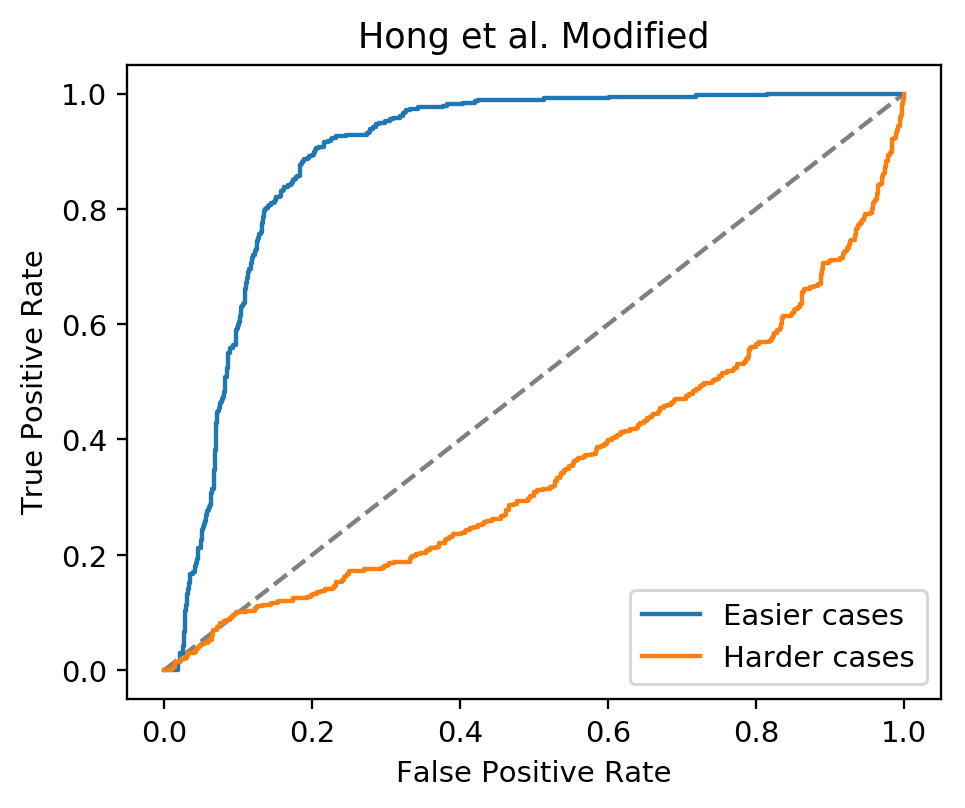

In [34]:
easy_yuzhen, easy_no_nans = remove_nans(test_db.get_data(variables=['yuzhen_new'], samples=easy_samples))
hard_yuzhen, hard_no_nans = remove_nans(test_db.get_data(variables=['yuzhen_new'], samples=hard_samples))

print(easy_yuzhen.shape, easy_no_nans[0].shape)
print(hard_yuzhen.shape, hard_no_nans[0].shape)
    
plt.plot([0,1], [0,1], '--', color='gray')
    
fpr, tpf, _ = roc_curve(easy_l[easy_no_nans[0]], easy_yuzhen, 1)
plt.plot(fpr, tpf, label='Easier cases')

fpr, tpf, _ = roc_curve(hard_l[hard_no_nans[0]], hard_yuzhen, 1)
plt.plot(fpr, tpf, label='Harder cases')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Hong et al. Modified')
plt.legend(loc='lower right')
set_plt_params(plt, dpi=210)
bbox = mt.Bbox(array([[0.05, 0.05], [4.6, 3.75]]))
# plt.savefig(img_full_path('roc_yuzhen_new_blur_type.eps'), bbox_inches=bbox, pad_inches=0.)
plt.show()

Then, for the simple sharpness metric GSM:

(1134, 1)
(1134, 1)
setting dpi = 210, figsize = (4, 5)


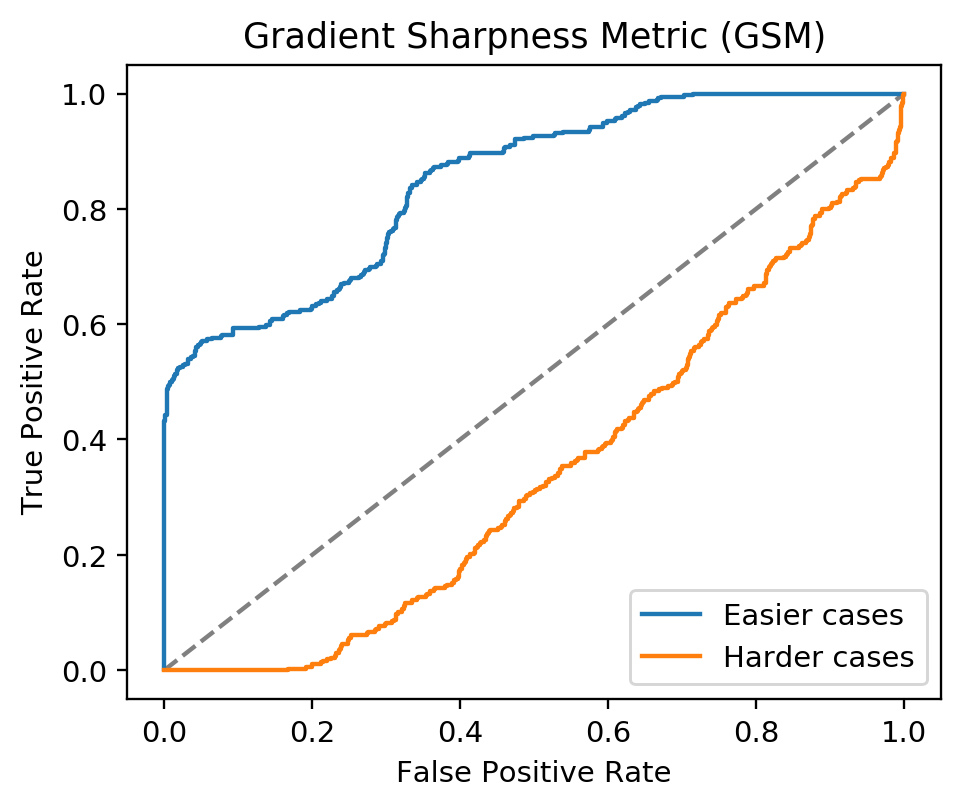

In [35]:
easy_sh = test_db.get_data(variables=['sharpness'], samples=easy_samples)
hard_sh = test_db.get_data(variables=['sharpness'], samples=hard_samples)

print(easy_sh.shape)
print(hard_sh.shape)
    
plt.plot([0,1], [0,1], '--', color='gray')
    
fpr, tpf, _ = roc_curve(easy_l, easy_sh, 1)
plt.plot(fpr, tpf, label='Easier cases')

fpr, tpf, _ = roc_curve(hard_l, hard_sh, 1)
plt.plot(fpr, tpf, label='Harder cases')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Gradient Sharpness Metric (GSM)')
plt.legend(loc='lower right')
set_plt_params(plt, dpi=210)
bbox = mt.Bbox(array([[0.05, 0.05], [4.6, 3.75]]))
# plt.savefig(img_full_path('roc_sharpness_blur_type.eps'), bbox_inches=bbox, pad_inches=0.)
plt.show()

Then, for the FFT-based metric:

setting dpi = 210, figsize = (4, 5)


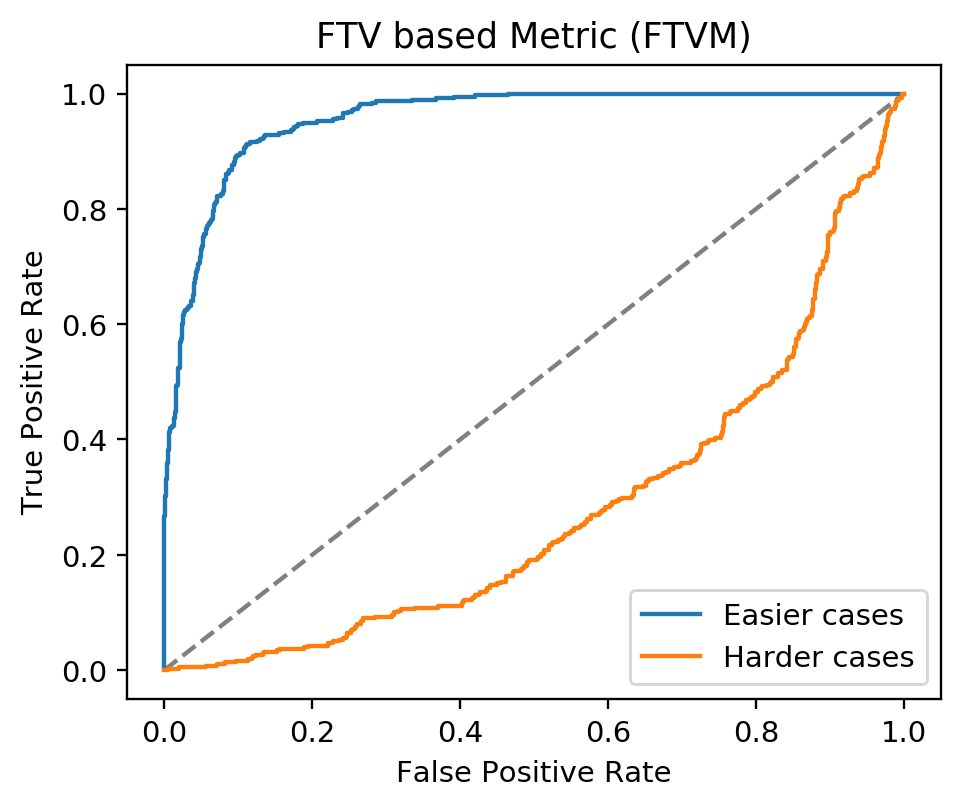

In [36]:
easy_fft = test_db.get_data(variables=['fft_features'], samples=easy_samples)
hard_fft = test_db.get_data(variables=['fft_features'], samples=hard_samples)
    
plt.plot([0,1], [0,1], '--', color='gray')

easy_fft = (easy_fft[:,0] + easy_fft[:,1])/2
hard_fft = (hard_fft[:,0] + hard_fft[:,1])/2
    
fpr, tpf, _ = roc_curve(easy_l, easy_fft, 1)
plt.plot(fpr, tpf, label='Easier cases')

fpr, tpf, _ = roc_curve(hard_l, hard_fft, 1)
plt.plot(fpr, tpf, label='Harder cases')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('FTV based Metric (FTVM)')
plt.legend(loc='lower right')
set_plt_params(plt, dpi=210)
bbox = mt.Bbox(array([[0.05, 0.05], [4.6, 3.75]]))
# plt.savefig(img_full_path('roc_fft_blur_type.eps'), bbox_inches=bbox, pad_inches=0.)
plt.show()

Then, for the Sieberth et al.'s method:

setting dpi = 210, figsize = (4, 5)


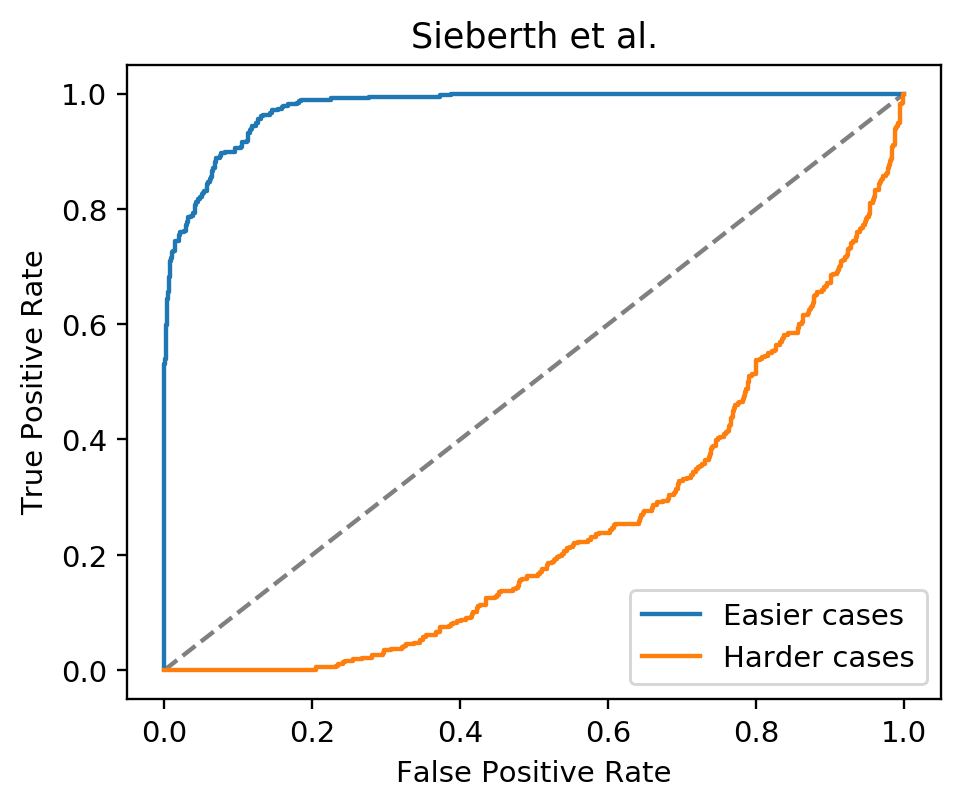

In [37]:
easy_sieds = test_db.get_data(variables=['sieberth'], samples=easy_samples)
hard_sieds = test_db.get_data(variables=['sieberth'], samples=hard_samples)
    
plt.plot([0,1], [0,1], '--', color='gray')
    
fpr, tpf, _ = roc_curve(easy_l, easy_sieds, 1)
plt.plot(fpr, tpf, label='Easier cases')

fpr, tpf, _ = roc_curve(hard_l, hard_sieds, 1)
plt.plot(fpr, tpf, label='Harder cases')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Sieberth et al.')
plt.legend(loc='lower right')
set_plt_params(plt, dpi=210)
bbox = mt.Bbox(array([[0.05, 0.05], [4.6, 3.75]]))
# plt.savefig(img_full_path('roc_sieds_blur_type.eps'), bbox_inches=bbox, pad_inches=0.)
plt.show()